In [197]:
# default_exp interpretability.error_checker

In [63]:
# export

import pandas as pd
import numpy as np

from pathlib import Path
import os, shutil

from subprocess import *

from typing import Optional, List

In [6]:
from pprint import pprint

In [7]:
# export

#Logging configuration

import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

## error_checker

> This module provides a tool for analyzing java source code and get compilation error report. Provides a python interface for a custom jar

> @Alvaro 05 April 2021

This methods lets us execute external jar files from python.

### Errors definition

Java errors definition in order to get generic enough error descriptions

As there isn't any oficial documentation, this is based on some posts:

- [Compile-time errors](!https://student.cs.uwaterloo.ca/~cs133/Resources/Java/Debugging/compile.shtml)
- [Compile and Runtime Errors in Java](!https://introcs.cs.princeton.edu/java/11cheatsheet/errors.pdf)
- [Compile time error messages - Glossary](!https://www.mindprod.com/jgloss/compileerrormessages.html#UNEXPECTEDSYMBOLS)

In [29]:
#export

# Most generic errors --> the ones to be replaced first without loosing most specific errors

fixed_errors = {
    "cannot_find_symbol": "cannot find symbol",
    "non_existing_package": "package [a-zA-Z0-9_\.\$]+ does not exist",
}


# Errors to be found based on regex
regex_errors = {
    "not_visible_package": "package [a-zA-Z0-9_\.]+ is not visible",
    "exception": "^[A-Za-z]+Exception$",
    "special_char_expected": "'?(\(|\)|;|\[|\]|\<|\>)'? expected",
    "non_applicable_method_diff_len": "method .* cannot be applied .* reason: actual and formal argument lists differ in length",
    "non_applicable_method_varargs_mismatch": "method .* cannot be applied .* reason: varargs mismatch",
    "ambiguous_reference": "reference to [A-Za-z]+ is ambiguous",
    "no_suitable_method": "^no suitable method found for",
#     "no_suitable_method_diff_length": "no suitable method found for .* actual and formal argument lists differ in length",
#     "no_suitable_method_varargs_mismatch": "no suitable method found for .* varargs mismatch",
    "non_static_var_from_static_context": "non-static variable .* cannot be referenced from a static context",
    "cannot_be_dereferenced": "<?[A-Za-z]+>? cannot be dereferenced",
    "method_cannot_be_applied_to_given_types": "method .* in class .* cannot be applied to given types",
    "no_suitable_constructor": "^no suitable constructor found for",
    "unexpected_type": "unexpected type(\s)*required:(\s)*([a-zA-Z0-9_]+)(\s)*found:",
    "incomparable_types": "^incomparable types:",
    "deprecated_usage": "has been deprecated and marked for removal$",
    "non_static_method_referenced_from_static_context": "non-static method [a-zA-Z0-9_\.]+\s*\(\s*\)\s*cannot be referenced from a static context",
    "name_clash": "^name clash:",
    "cannot_inherit_from": "^cannot inherit",
    "unclosed_literal": "unclosed [a-zA-Z]+ literal",
    "try_without_catch_finally_declarations": "'try' without 'catch', 'finally' or resource declarations",
}

In [31]:
#export

# Most generic errors --> the ones to be replaced first without loosing most specific errors

fixed_errors = {
    "cannot_find_symbol": "cannot find symbol",
    "non_existing_package": "package [a-zA-Z0-9_\.\$]+ does not exist",
}


# Errors to be found based on regex
regex_errors = {
    "not_visible_package": "package [a-zA-Z0-9_\.]+ is not visible",
    "exception": "^[A-Za-z]+Exception$",
    "special_char_expected": "'?(\(|\)|;|\[|\]|\<|\>)'? expected",
    "non_applicable_method_diff_len": "method .* cannot be applied .* reason: actual and formal argument lists differ in length",
    "non_applicable_method_varargs_mismatch": "method .* cannot be applied .* reason: varargs mismatch",
    "ambiguous_reference": "reference to [A-Za-z]+ is ambiguous",
    "no_suitable_method": "^no suitable method found for",
#     "no_suitable_method_diff_length": "no suitable method found for .* actual and formal argument lists differ in length",
#     "no_suitable_method_varargs_mismatch": "no suitable method found for .* varargs mismatch",
    "non_static_var_from_static_context": "non-static variable .* cannot be referenced from a static context",
    "cannot_be_dereferenced": "<?[A-Za-z]+>? cannot be dereferenced",
    "method_cannot_be_applied_to_given_types": "method .* in class .* cannot be applied to given types",
    "no_suitable_constructor": "^no suitable constructor found for",
    "unexpected_type": "unexpected type(\s)*required:(\s)*([a-zA-Z0-9_]+)(\s)*found:",
    "incomparable_types": "^incomparable types:",
    "deprecated_usage": "has been deprecated and marked for removal$",
    "non_static_method_referenced_from_static_context": "non-static method [a-zA-Z0-9_\.]+\s*\(\s*\)\s*cannot be referenced from a static context",
    "name_clash": "^name clash:",
    "cannot_inherit_from": "^cannot inherit",
    "unclosed_literal": "unclosed [a-zA-Z]+ literal",
    "try_without_catch_finally_declarations": "'try' without 'catch', 'finally' or resource declarations",
    "constructor_cannot_be_applied": "^constructor [a-zA-Z0-9\.\_\$]+ .* cannot be applied to given types",
    "cannot_infer_type_for_local_var": "^cannot infer type for local variable",
    "abstract_class_cannot_be_instantiated": "^[a-zA-Z0-9_\.\$\<\>]+ is abstract; cannot be instantiated",
    "type_not_allowed": "'[a-zA-Z0-9_\.\<\>]+' type not allowed here",
    "class_doesnot_override_abst_mthd": "[a-zA-z0-9\.\$\<\>]+ is not abstract and does not override abstract method",
    "element_has_private_access": "^[a-zA-z0-9\.\$\<\>\(\)\s]+ has private access in",
    "element_has_protected_access": "[a-zA-z0-9\.\$\<\>\(\)\s]+ has protected access in",
    "element_cannot_be_accessed_from_outside_pkg": "cannot be accessed from outside package$",
    "illegal_static_declaration": "^Illegal static declaration in inner class",
    "pkg_deprecated_marked_for_removal": "[a-zA-Z0-9_\.\$\<\>]+ in [a-zA-Z0-9_\.\$\<\>]+ has been deprecated and marked for removal",
    "cannot_inherit_from": "^cannot inherit from final java.lang.Module",
    
    
}

In [32]:
# export

# Errors to be found based on specific names
# Note just a part of the error description is included but it is searched based on str coincidence

named_errors = {
    "method_doesnot_override_implement_super": "method does not override or implement a method",
    "unexpected_lambda": "lambda expression not expected",
    "expected_structure": "class, interface, or enum expected",
    "illegal_parenthesized_expression": "illegal parenthesized expression",
    "incompatible_types": "incompatible types",
    "for_each_not_applicable": "for-each not applicable to expression type",
    "return_required": "return required",
    #"cannot_infer_type_for_local variable": "cannot infer type for local variable",
    "element_cannot_be_accessed_from_outside_the_pkg": "cannot be accessed from outside package",
    "private_access": "has private access in",
    "unclosed_character_literal": "unclosed character literal",
    "not_a_statement": "not a statement"
}


# Warning (errors) to be found based on names (str coincidence)

warnings = {
    "warn_deprecated_API": "uses or overrides a deprecated API",
    "warn_unsafe_operations": "uses unchecked or unsafe operations",
    "xdiags_warning": "recompile with -Xdiags:verbose to get full output",
    "xlint_warning": "Recompile with -Xlint",
    "non_varargs-warning": "non-varargs call of varargs method with inexact argument type for last parameter"
}

In [34]:
# export

name_coincidence_errors = {
    **named_errors,
    **warnings
}

In [14]:
fake_dict = {
    "error": [
        "package com.sun.tools.javac.$code is not visible   (package com.sun.tools.javac.code is declared in module jdk.compiler, which does not export it to the unnamed module)",
        ""
    ]
}

In [12]:
fake_df = pd.DataFrame(fake_dict)

In [15]:
fake_df.loc[fake_df['error'].str.contains("package [a-zA-Z0-9_\.]+ is not visible", regex=True)]
# df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=True), error_column]

,error
0,package com.sun.tools.javac.code is not visibl...


### Utils

All the error analysis is performed by an external tool originally written in Java, that's why we specify a utility method for executing jar programs from python

In [26]:
# export

def jarWrapper(*args):
    """
    Function for executing jar files from python
    :param args: Arguments to be passed for the executed program
    :returns: Output produced by the executed jar
    """
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith(b'\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    
    ret += stdout.split(b'\n')
    if stderr != '':
        ret += stderr.split(b'\n')
        
    if '' in ret:
        ret.remove('')
    return ret

In [25]:
# export

def process_chars_for_bpes(code_snippet):
    return code_snippet.replace('\n', '<n>').replace('\t', '<t>').replace('@', '<@>')

## Error checker

This class provides an interface for performing the error analysis, returning the results as a pandas DataFrame for further exploration/analysis.

In [12]:
# export

class JavaErrorChecker():
    def __init__(self, jar_path):
        self.jar_path = jar_path

    def perform_analysis(self, code_df, idx_column, error_column):
        """
        Performs the error analysis and gets the report error report
        :param  code_df: Pandas Dataframe with the required structure containing the code to be analyzed
        :param idx_column: Column name to reference the snippets in the generated report
        :param error_column: Column name to reference the error details in the generated report
        """
        
        self.__create_aux_dirs()
        code_df = self.__process_df(code_df)
        out_csv_name = "error_analysis_report.csv"
        code_csv_name = "code.csv"
        code_df.to_csv(str(self.resources_path/code_csv_name), index=False)
        args = [self.jar_path, code_csv_name, out_csv_name]
        
        try:
            jar_result = jarWrapper(*args)
            logging.info(f'jar program produced this output: {jar_result}')
        except Exception as e:
            logging.error(f'An error ocurred when trying to execute the jar program')
            #print(e.message, e.args)    
            
        processed_df =  self.__process_results(out_csv_name, idx_column, error_column)
        self.__remove_aux_files()
        
        return processed_df
        
            
    def __process_results(self, out_name, idx_column, error_column):
        errors_report_df = pd.read_csv(str(self.resources_path/out_name), delimiter = '\t')
        clean_df = self.__get_generic_errors(errors_report_df, fixed_errors, regex_errors, name_coincidence_errors, error_column)
        dimension_based_df = self.__get_error_dims_records(clean_df, idx_column, error_column)
        return dimension_based_df
        
    def __get_generic_errors(self, df, fixed_errors, regex_errors, named_errors, error_column):
        """
        Performs processing for error names
        :param df: Pandas dataframe containing errors info.
        :param fixed_errors: Dictionary containing the names-regex for more generic error names
        :param regex_errors: Dictionary containing regex defining generic error names
        :param named_errors: Dictionary containing generic error names
        :param error_column: Column name to access to access errors in df
        :returns: Processed dataframe
        """
        logging.info('Processing external report.')
        df_copy = df.copy()
    
        # Replace most generic errors first
        for k, v in fixed_errors.items():
            df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=True), error_column] = k

        for k, v in regex_errors.items():
            df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=True), error_column] = k

        for k, v in named_errors.items():
            df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=False), error_column] = k

        return df_copy
    
    
    def __get_error_dims_records(self, df, idx_column, error_column):
        logging.info('Getting error dimensions.')
        # Group/count errors for each class
        grouped_errors = df.groupby([idx_column, error_column])[error_column].count().reset_index(name='count')
        
        # Turn errors rows into columns (dimensions for vectors)
        pivot_df = grouped_errors.pivot(index=idx_column, columns=error_column, values='count').reset_index()
        pivot_df = pivot_df.fillna(0)
        
        return pivot_df
    
    def __remove_aux_files(self):
        """
        Removes auxiliar - tmp directories/files created for the functioning of the external package
        """
        logging.info('Removing auxiliar directories/files.')
        shutil.rmtree(str(self.base_path))
        
    def __create_aux_dirs(self):
        logging.info('Creating auxiliar directories.')
        self.out_path = Path(".")
        # Configure directories for jar tool
        self.base_path = self.out_path / "java"
        self.resources_path = self.base_path / "resources"
        self.compiled_path = self.resources_path / "compiled"
        self.base_path.mkdir(exist_ok=True)
        self.resources_path.mkdir(exist_ok=True)
        self.compiled_path.mkdir(exist_ok=True)
        
    def __process_df(self, df):
        """
        Function to process the df according to the format required by the
        java analyzer
        """
        df = df.copy()
        
        # Add special tokens expected by the analyzer
        df['code'] = df['code'].apply(lambda method: process_chars_for_bpes(method))
        
        # Format the dataframe appropriately as the analyzer program expects
        columns = df.columns
        
        if "idx" not in columns:
            idx_column = [i for i in range(df.shape[0])]
            df['idx'] = idx_column
        if "stop_column" not in columns:
            stop_column = ['*stop*' for _ in range(df.shape[0])]
            df['stop_column'] = stop_column
            
        df = df[['idx', 'code', 'stop_column']]
        
        return df

### Usage example

In [13]:
java_df = pd.read_csv('/tf/main/dvc-ds4se/code/searchnet/clean_java.csv')
# java_df = pd.read_csv('/tf/main/dvc-ds4se/code/searchnet/[codesearchnet-java-1597073966.81902].csv')

In [14]:
java_df.head()

,Unnamed: 0,code,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count
0,0,protected final void fastPathOrderedEmit(U val...,134.0,"['protected', 'final', 'void', 'fastPathOrdere...",7.0,src,fastPathOrderedEmit,20.0,3.0,test,131.0
1,1,@CheckReturnValue\n @NonNull\n @Schedule...,63.0,"['@', 'CheckReturnValue', '@', 'NonNull', '@',...",1.0,src,amb,4.0,1.0,test,43.0
2,2,"@SuppressWarnings(""unchecked"")\n @CheckRetu...",107.0,"['@', 'SuppressWarnings', '(', '""unchecked""', ...",3.0,src,ambArray,11.0,1.0,test,82.0
3,3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",79.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,4.0,1.0,test,50.0
4,4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",91.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,5.0,2.0,test,62.0


In [15]:
java_samples = java_df.sample(100)

In [16]:
print(java_samples)

        Unnamed: 0                                               code  \
188471       11653  public void setLabel (String label)\n    {\n  ...   
276543        5307  @Override\n    public void expireSchemaElement...   
306645        5422  public ProjectBuilder read(final URI file) thr...   
113072       26210  protected String encryptQY(String randomStr, S...   
180907        4082  public EClass getOBD() {\n\t\tif (obdEClass ==...   
...            ...                                                ...   
98648        11780  public static float[] getDash( String dashStr ...   
38995        12107  public Collection<? extends Action> getProject...   
13150        13155  protected List<DatasetScanConfig.Namer> readDa...   
85725        28857  public Domain withDomainEntries(DomainEntry......   
138231       21381  @Override\n    protected Object getAttributeLo...   

        code_len                                        code_tokens  \
188471      29.0  ['public', 'void', 'setLabel', '('

In [26]:
java_samples['code'] = java_samples['code'].apply(lambda method: process_chars_for_bpes(method))

In [27]:
idx_column = [i for i in range(java_samples.shape[0])]

In [28]:
stop_column = ['*stop*' for _ in range(java_samples.shape[0])]

In [29]:
java_samples['idx'] = idx_column
java_samples['stop_column'] = stop_column

In [30]:
java_samples = java_samples[['idx', 'code', 'stop_column']]

In [31]:
java_samples.head()

,idx,code,stop_column
447269,0,public int getWidth(int y)<n> {<n> i...,*stop*
485349,1,public static Properties loadPropertiesFromInp...,*stop*
205726,2,public void setEmptyText(CharSequence text) {<...,*stop*
386250,3,"public Resource getResource(String path, long ...",*stop*
404420,4,"<<@>>SuppressWarnings(""deprecation"")<n> pri...",*stop*


In [33]:
java_samples.to_csv('java/resources/java_samples.csv', index=False)

In [158]:
Path("java/resources/java_samples.csv").exists()

False

In [160]:
! ls 

 0.0_mgmnt.prep.i.ipynb
 0.10_error_checker.ipynb
 0.1_mgmnt.prep.conv.ipynb
 0.3_mgmnt.prep.bpe.ipynb
 0.6_mgmnt.prep.nltk.ipynb
 0.7_metrics_module_python.ipynb
 0.8_metrics_module_java.ipynb
 0.9_metrics_example.ipynb
 1.0_exp.i.ipynb
'1.1_exp.info-[inspect].ipynb'
 1.1_exp.info.ipynb
 1.2_exp.csnc.ipynb
 1.2_exp.gen.code.ipynb
 1.3_exp.csnc_python.ipynb
 2.0_repr.codebert.ipynb
 2.0_repr.i.ipynb
 2.1_repr.codeberta.ipynb
 2.1_repr.roberta.train.ipynb
 2.2_repr.roberta.eval.ipynb
 2.3_repr.word2vec.train.ipynb
 2.6_repr.word2vec.eval.ipynb
 2.7_repr.distmetrics.ipynb
 2.8_repr.sentence_transformers.ipynb
 3.1_mining.unsupervised.traceability.eda.ipynb
 3.2_mining.unsupervised.eda.traceability.d2v.ipynb
 3.2_mining.unsupervised.mutual_information.traceability.approach.sacp-w2v.ipynb
 3.2_mining.unsupervised.mutual_information.traceability.approach.sacp.w2v.ipynb
 3.2_mutual_information_theory.eval.ipynb
 3.4_facade.ipynb
 4.0_mining.ir.ipynb
 5.0_experiment.mining.ir.unsupervised.d2v

In [34]:
jar_path = '/tf/main/tools/soft-sintax-checker.jar'

In [37]:
java_error_checker = JavaErrorChecker(jar_path)

In [38]:
error_report_df = java_error_checker.perform_analysis(java_samples, 'ID Class', ' error message')

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [151]:
error_report_df

error message,ID Class,cannot_find_symbol,for_each_not_applicable,illegal start of expression,illegal start of type,illegal_parenthesized_expression,invalid method declaration; return type required,non_existing_package,not a statement,special_char_expected
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
94,95,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,96,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96,97,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
97,98,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
error_report_df.describe()

error message,ID Class,cannot_find_symbol,for_each_not_applicable,illegal start of expression,illegal start of type,illegal_parenthesized_expression,invalid method declaration; return type required,non_existing_package,not a statement,special_char_expected
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,49.949495,6.828283,0.010101,0.040404,0.101010,0.010101,0.060606,0.121212,0.010101,0.616162
std,28.807019,8.145414,0.100504,0.197907,0.334876,0.100504,0.239821,0.410891,0.100504,1.267386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.500000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,59.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,7.000000


In [41]:
columns = [column for column in error_report_df.columns if column != 'ID Class']

In [42]:
error_report_df.columns

Index(['ID Class', 'cannot_find_symbol', 'for_each_not_applicable',
       'illegal start of expression', 'illegal start of type',
       'illegal_parenthesized_expression',
       'invalid method declaration; return type required',
       'non_existing_package', 'not a statement', 'special_char_expected'],
      dtype='object', name=' error message')

In [86]:
columns

['cannot_find_symbol',
 'for_each_not_applicable',
 'illegal start of expression',
 'illegal start of type',
 'illegal_parenthesized_expression',
 'invalid method declaration; return type required',
 'non_existing_package',
 'not a statement',
 'special_char_expected']

In [44]:
error_report_df[columns].describe()['cannot_find_symbol']['mean']

6.828282828282828

## Errors selection

Run the error analysis several times in order to get some statistics about the ocurrence of errors.
As the error "space" is huge (all possible errors caught by the compiler) several errors are selected according to the frequency of occurence.

In [160]:
from collections import defaultdict

In [45]:
from tqdm import tqdm

In [46]:
def get_code_df_samples(code_df, n_samples):
    """
    Function to get processed samples for running the experiments.
    """
    samples = code_df.sample(n_samples)
    # Preprocess for special chars.
    samples['code'] = samples['code'].apply(lambda method: process_chars_for_bpes(method))
    # Include auxiliar columns for external tool
    idx_column = [i for i in range(samples.shape[0])]
    stop_column = ['*stop*' for _ in range(samples.shape[0])]
    samples['idx'] = idx_column
    samples['stop_column'] = stop_column
    samples = samples[['idx', 'code', 'stop_column']]
    
    return samples


def run_multiple_error_experiments(code_df, error_check_jar_path, n_samples, n_runs):
    """
    Function to execute the experiment several times and gather some statistics
    about the ocurrence of errors.
    :param code_df: pandas DataFrame containing code to be anaylzed
    :param error_check_jar_path: Path containing the jar pkg used to perform the analysis
    :param n_samples: Number of samples to get each experiment
    :param n_runs:
    
    :return: Dict containing the stats. of errors for the experiments.
    """
    error_checker = JavaErrorChecker(error_check_jar_path)
    
    errors_count = {}
    for r in tqdm(range(n_runs)):
        samples_df = get_code_df_samples(code_df, n_samples)
        results_df = error_checker.perform_analysis(samples_df, 'ID Class', ' error message')
        error_columns = [column for column in results_df.columns if column != 'ID Class']
        # TODO: Check stats for corresponding errors
        description = results_df[error_columns].describe()
        iter_stats_name = f'stats_iter_{r}'
        
        for error in error_columns:
            mean = description[error]['mean']
            std = description[error]['std']
            max_ = description[error]['max']
            
            if error in errors_count:
                errors_count[error]['count'] += 1
            else:
                errors_count[error] = {
                    'count': 1,
                    'mean': [0] * n_runs,
                    'std': [0] * n_runs,
                    'max': [0] * n_runs
                }
            
            errors_count[error]['mean'][r] = mean
            errors_count[error]['std'][r] = std
            errors_count[error]['max'][r] = max_
                
    return errors_count

In [47]:
java_df.head()

,Unnamed: 0,code,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count
0,0,protected final void fastPathOrderedEmit(U val...,134.0,"['protected', 'final', 'void', 'fastPathOrdere...",7.0,src,fastPathOrderedEmit,20.0,3.0,test,131.0
1,1,@CheckReturnValue\n @NonNull\n @Schedule...,63.0,"['@', 'CheckReturnValue', '@', 'NonNull', '@',...",1.0,src,amb,4.0,1.0,test,43.0
2,2,"@SuppressWarnings(""unchecked"")\n @CheckRetu...",107.0,"['@', 'SuppressWarnings', '(', '""unchecked""', ...",3.0,src,ambArray,11.0,1.0,test,82.0
3,3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",79.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,4.0,1.0,test,50.0
4,4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",91.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,5.0,2.0,test,62.0


In [48]:
errors_count = run_multiple_error_experiments(java_df, jar_path, n_samples=5000, n_runs=200)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
  0%|          | 1/200 [00:43<2:23:33, 43.29s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
  1%|          | 2/200 [01:25<2:21:11, 42.79s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
  2%|▏         | 3/200 [02:08<2:20:48, 42.89s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
  2%|▏         | 4/200 [05:47<6:07:01,

 17%|█▋        | 34/200 [27:11<1:58:49, 42.95s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 18%|█▊        | 35/200 [27:54<1:58:01, 42.92s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 18%|█▊        | 36/200 [28:37<1:57:27, 42.97s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 18%|█▊        | 37/200 [29:20<1:56:42, 42.96s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 19%|█▉        | 38/200 

 34%|███▍      | 68/200 [51:42<1:34:00, 42.73s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 34%|███▍      | 69/200 [52:24<1:33:22, 42.77s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 35%|███▌      | 70/200 [53:07<1:32:40, 42.77s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 36%|███▌      | 71/200 [53:50<1:31:48, 42.70s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 36%|███▌      | 72/200 

 51%|█████     | 102/200 [1:23:49<1:10:05, 42.92s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 52%|█████▏    | 103/200 [1:24:32<1:09:31, 43.00s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 52%|█████▏    | 104/200 [1:25:14<1:08:19, 42.71s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 52%|█████▎    | 105/200 [1:25:57<1:07:35, 42.69s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 53%|█████▎ 

 68%|██████▊   | 136/200 [1:48:22<45:32, 42.69s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 68%|██████▊   | 137/200 [1:49:05<44:46, 42.65s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 69%|██████▉   | 138/200 [1:49:48<44:11, 42.77s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 70%|██████▉   | 139/200 [1:50:30<43:24, 42.69s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 70%|███████   | 140

 85%|████████▌ | 170/200 [2:12:37<21:21, 42.73s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 86%|████████▌ | 171/200 [2:13:19<20:36, 42.64s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 86%|████████▌ | 172/200 [2:14:02<19:57, 42.78s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 86%|████████▋ | 173/200 [2:14:44<19:11, 42.65s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
 87%|████████▋ | 174

Explore errors ocurrence

In [72]:
MIN_OCURRENCE = 15

In [59]:
found_errors_count = {k: v['count'] for k,v in errors_count.items()}

In [84]:
found_errors_count = {k: v for k, v in sorted(found_errors_count.items(), key=lambda item: item[1], reverse=True)\
                      if v >= MIN_OCURRENCE}

In [85]:
q_errors = 0
for k, v in found_errors_count.items():
    if v < 14:
        break
    q_errors += 1
    print(k, v)
print(q_errors)

cannot_find_symbol 200
illegal_parenthesized_expression 200
incompatible_types 200
method_doesnot_override_implement_super 200
non_applicable_method_diff_len 200
non_existing_package 200
warn_deprecated_API 200
warn_unsafe_operations 200
xdiags_warning 200
xlint_warning 200
method_cannot_be_applied_to_given_types 199
expected_structure 189
cannot_be_dereferenced 186
for_each_not_applicable 177
deprecated_usage 146
non_static_var_from_static_context 144
unexpected_lambda 131
ambiguous_reference 118
non_applicable_method_varargs_mismatch 92
no_suitable_constructor 79
not_visible_package 67
no_suitable_method 55
unexpected_type 40
incomparable_types 32
invalid method declaration; return type required 23
private_access 22
method reference not expected here 20
non_varargs-warning 20
28


In [79]:
import matplotlib.pyplot as plt

In [80]:
list(found_error_names)

['cannot_find_symbol',
 'illegal_parenthesized_expression',
 'incompatible_types',
 'method_doesnot_override_implement_super',
 'non_applicable_method_diff_len',
 'non_existing_package',
 'warn_deprecated_API',
 'warn_unsafe_operations',
 'xdiags_warning',
 'xlint_warning',
 'method_cannot_be_applied_to_given_types',
 'expected_structure',
 'cannot_be_dereferenced',
 'for_each_not_applicable',
 'deprecated_usage',
 'non_static_var_from_static_context',
 'unexpected_lambda',
 'ambiguous_reference',
 'non_applicable_method_varargs_mismatch',
 'no_suitable_constructor',
 'not_visible_package',
 'no_suitable_method',
 'unexpected_type',
 'incomparable_types',
 'invalid method declaration; return type required',
 'private_access',
 'method reference not expected here',
 'non_varargs-warning']

([<matplotlib.axis.XTick at 0x7efca03e1d68>,
 <a list of 28 Text xticklabel objects>)

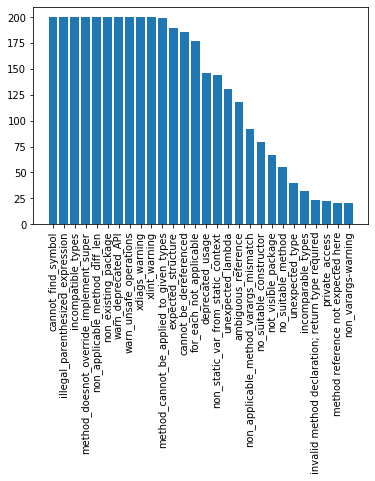

In [83]:
# Errors count

found_error_names = list(found_errors_count.keys())
found_errors_counts = [v for k,v in found_errors_count.items()]
found_errors_counts.sort(reverse=True)

plt.bar(found_error_names, found_errors_counts)
plt.xticks(range(len(found_error_names)), found_error_names, rotation=90)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


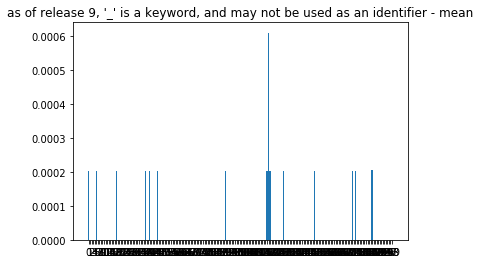

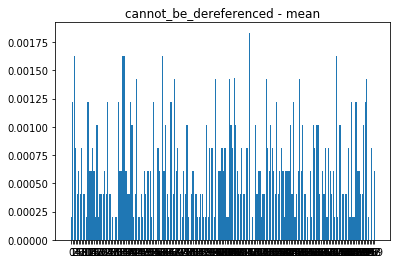

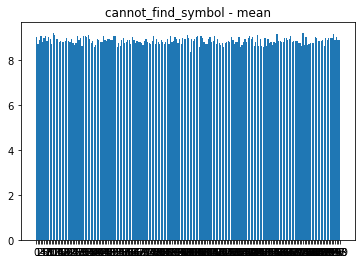

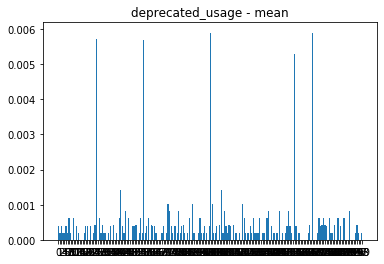

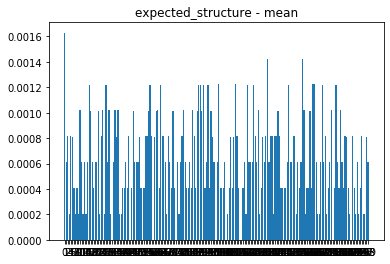

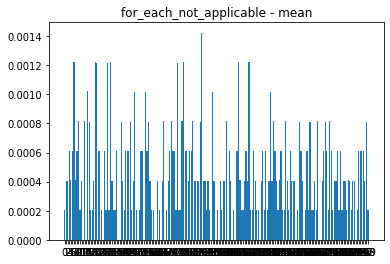

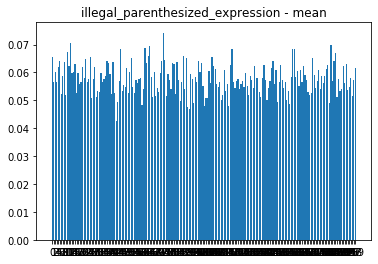

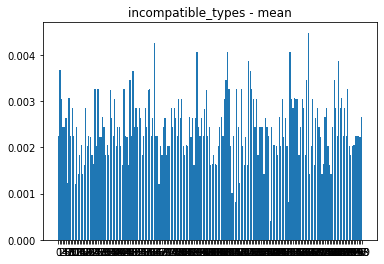

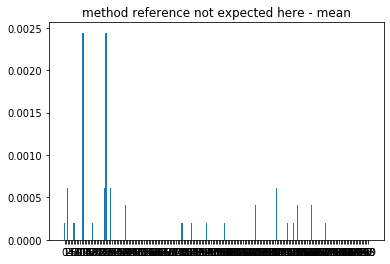

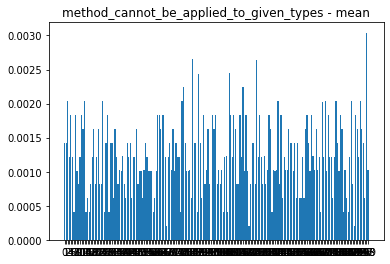

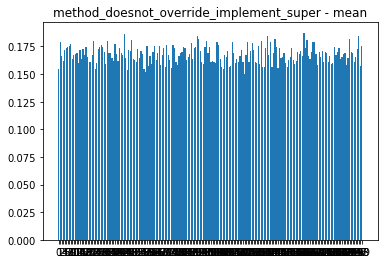

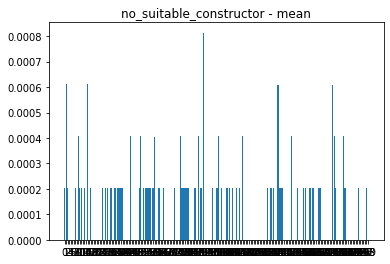

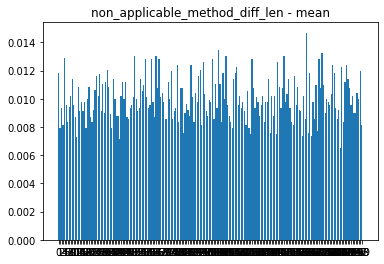

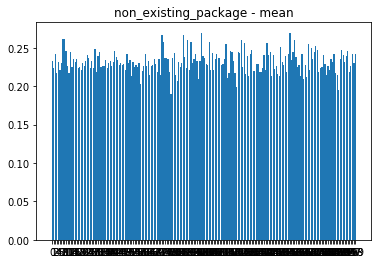

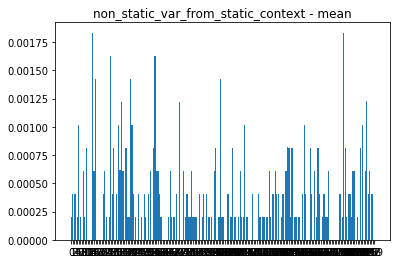

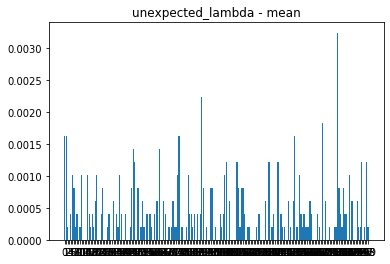

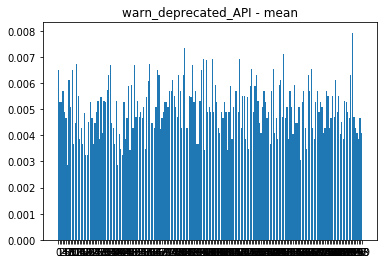

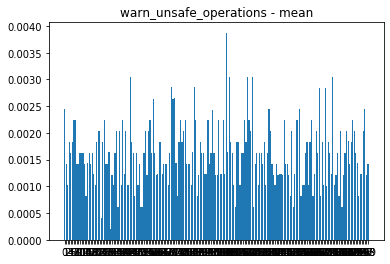

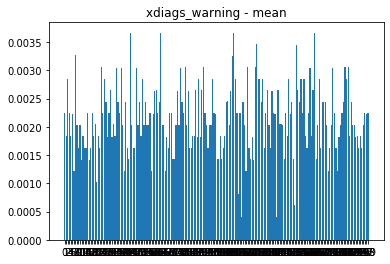

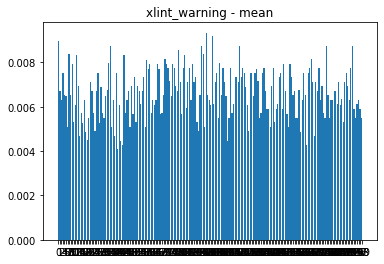

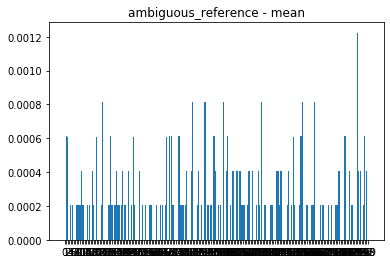

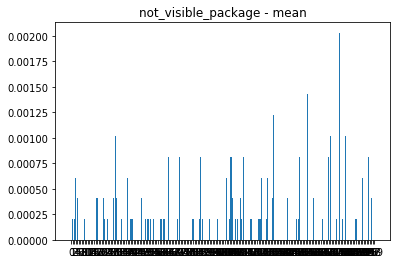

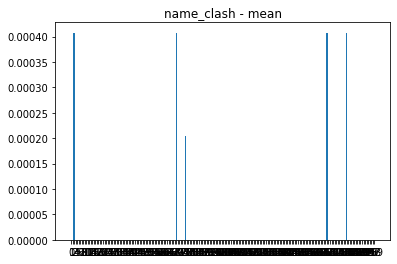

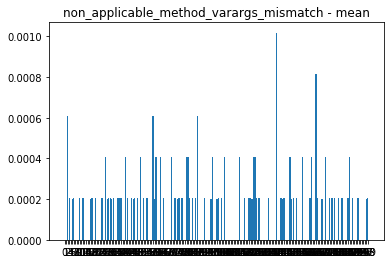

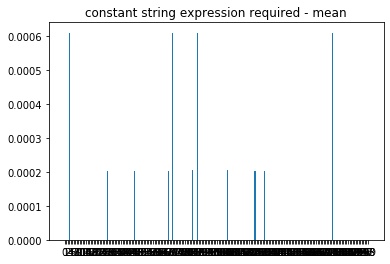

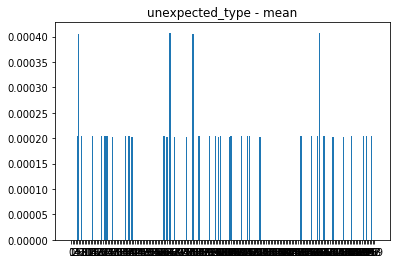

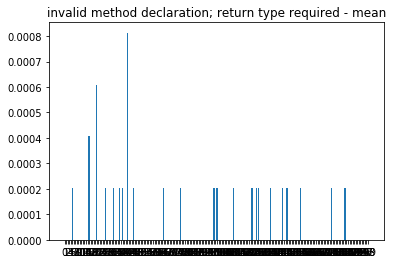

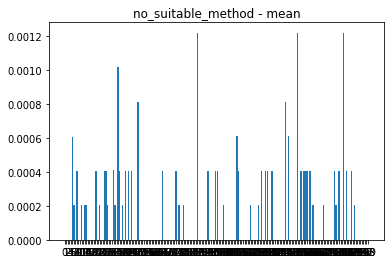

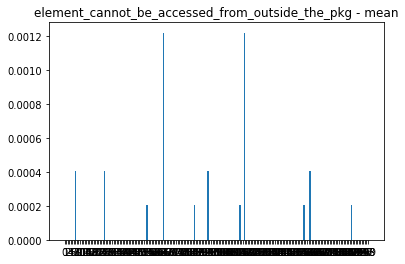

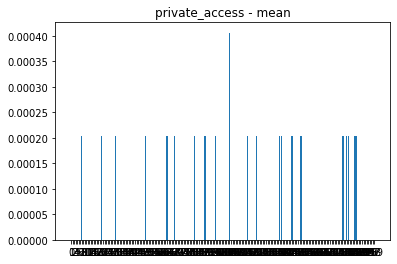

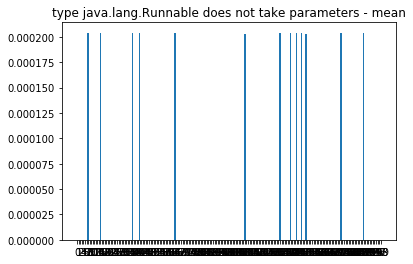

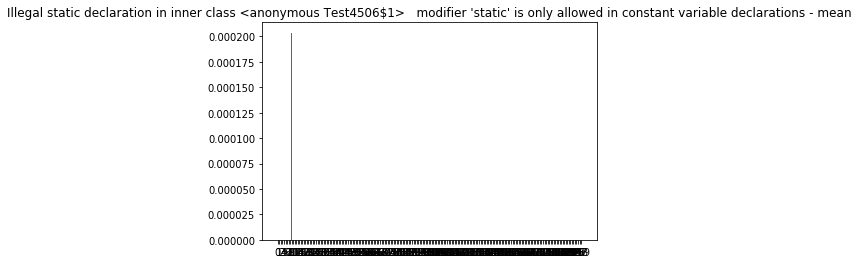

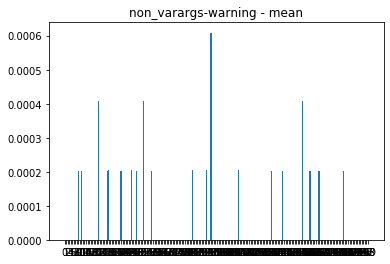

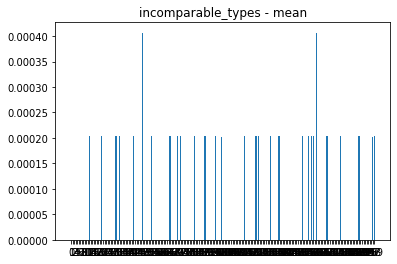

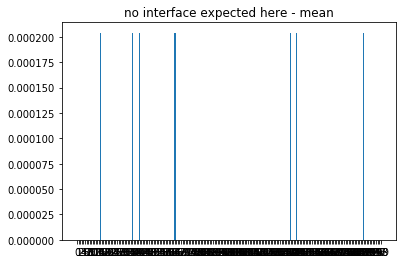

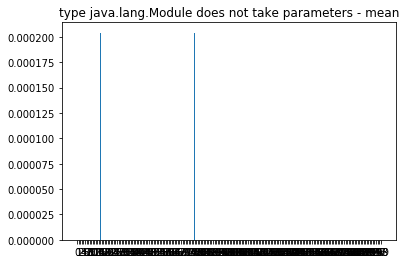

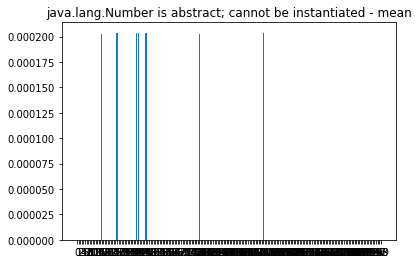

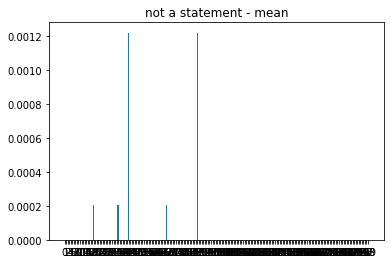

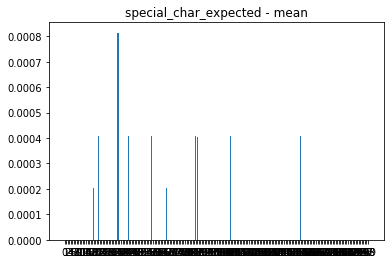

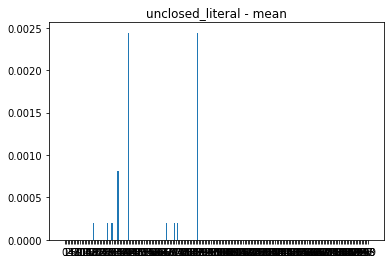

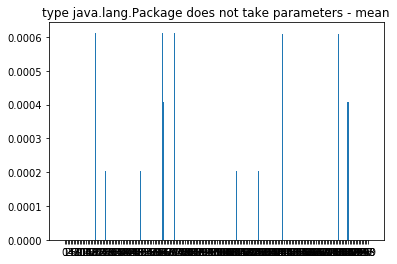

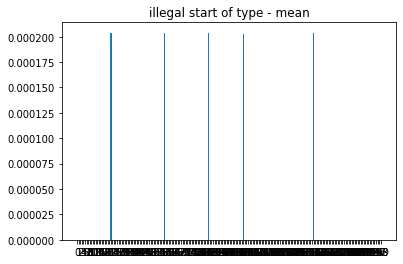

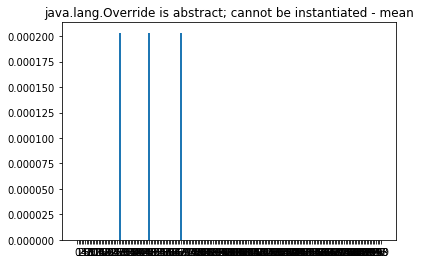

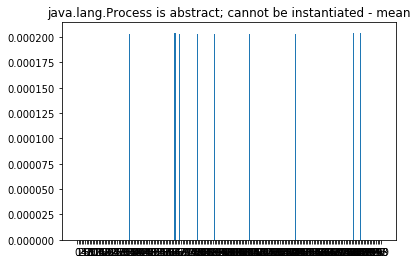

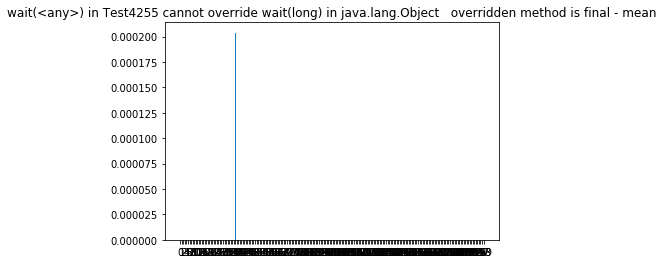

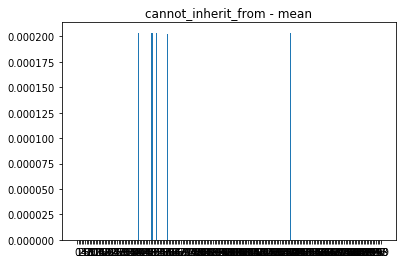

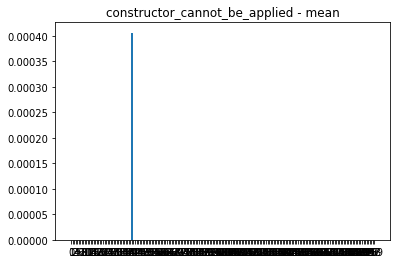

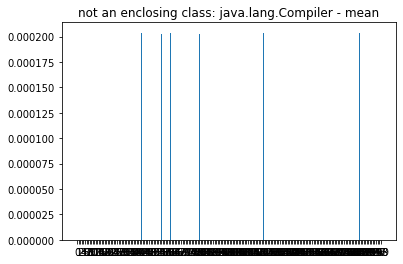

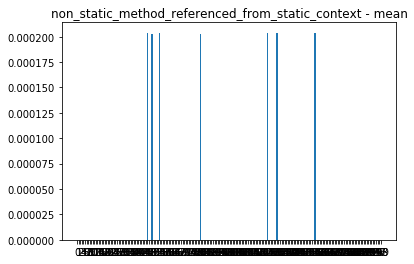

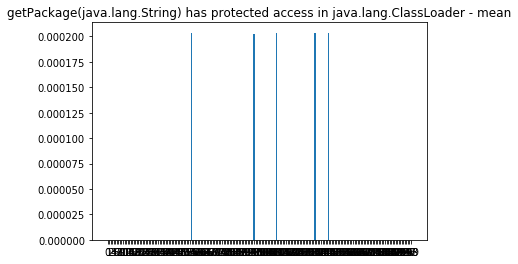

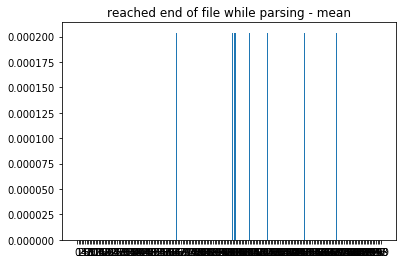

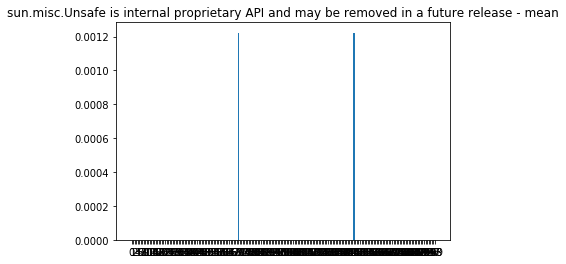

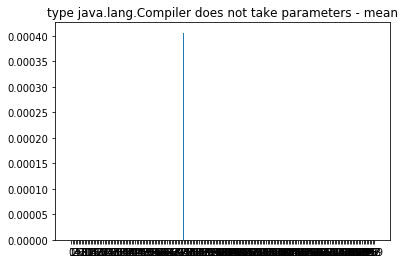

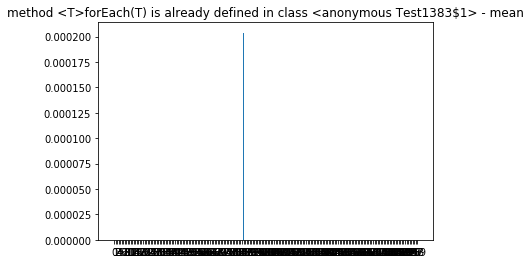

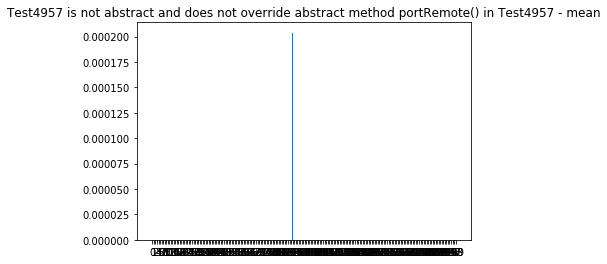

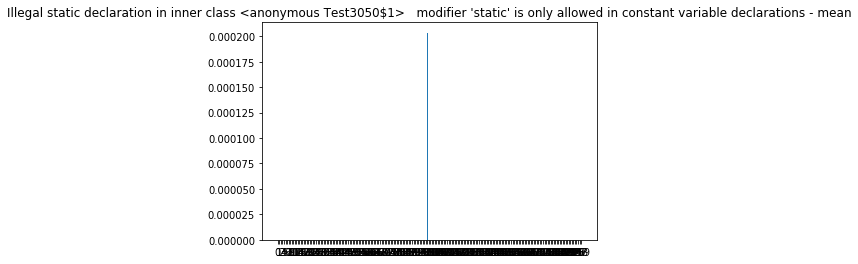

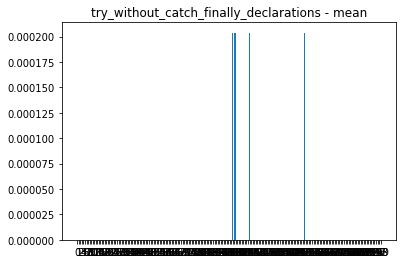

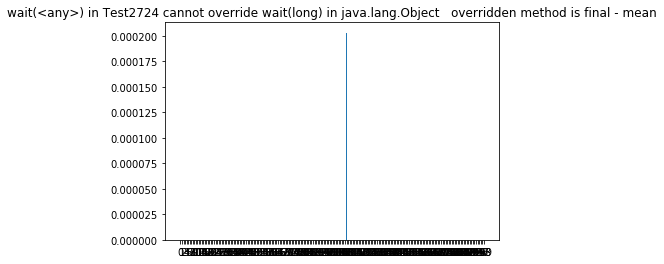

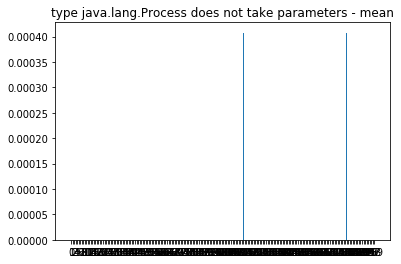

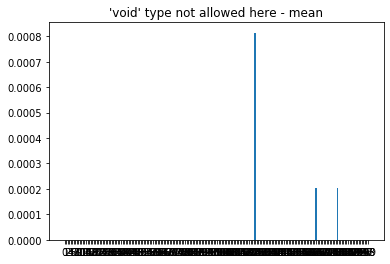

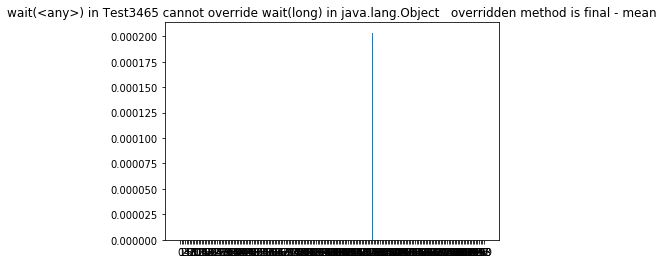

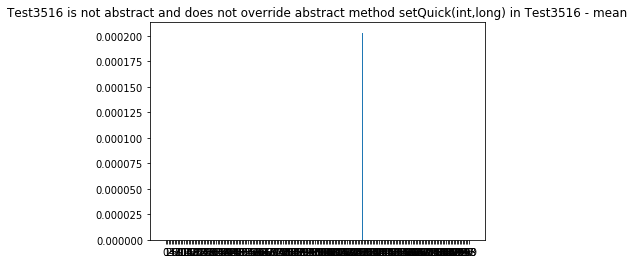

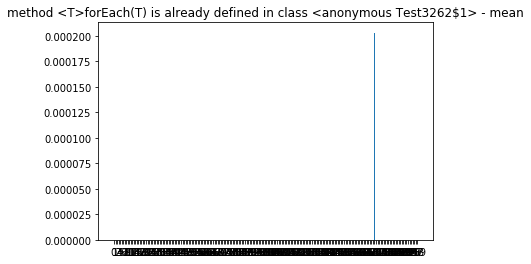

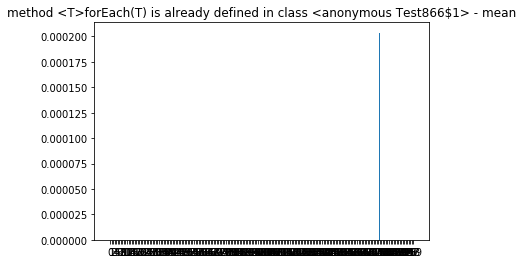

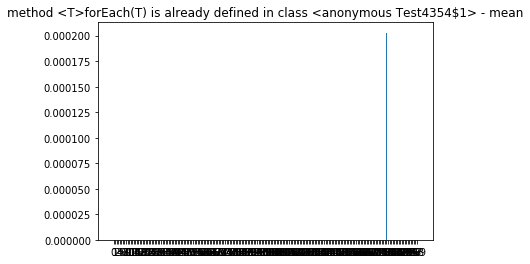

In [88]:
# Evolution of stats over runs

found_errors = list(errors_count.keys())

for err in found_errors:
    mean_vals = errors_count[err]['mean']
    std_vals = errors_count[err]['std']
    plt.figure()
    plt.title(f'{err} - mean')
    # Plot the evolution of mean over all the runs
    plt.bar(range(len(mean_vals)), mean_vals)
    plt.xticks(np.arange(0, len(mean_vals), 1))
    
plt.show()

In [89]:
selected_errors = list(found_errors_count.keys())

In [164]:
print(selected_errors)

['cannot_find_symbol', 'illegal_parenthesized_expression', 'incompatible_types', 'method_doesnot_override_implement_super', 'non_applicable_method_diff_len', 'non_existing_package', 'warn_deprecated_API', 'warn_unsafe_operations', 'xdiags_warning', 'xlint_warning', 'method_cannot_be_applied_to_given_types', 'expected_structure', 'cannot_be_dereferenced', 'for_each_not_applicable', 'deprecated_usage', 'non_static_var_from_static_context', 'unexpected_lambda', 'ambiguous_reference', 'non_applicable_method_varargs_mismatch', 'no_suitable_constructor', 'not_visible_package', 'no_suitable_method', 'unexpected_type', 'incomparable_types', 'invalid method declaration; return type required', 'private_access', 'method reference not expected here', 'non_varargs-warning']


In [3]:
# export

selected_errors = ['cannot_find_symbol',
    'illegal_parenthesized_expression',
    'incompatible_types',
    'method_doesnot_override_implement_super',
    'non_applicable_method_diff_len',
    'non_existing_package',
    'warn_deprecated_API',
    'warn_unsafe_operations',
    'xdiags_warning',
    'xlint_warning',
    'method_cannot_be_applied_to_given_types',
    'expected_structure',
    'cannot_be_dereferenced',
    'for_each_not_applicable',
    'deprecated_usage',
    'non_static_var_from_static_context',
    'unexpected_lambda',
    'ambiguous_reference',
    'non_applicable_method_varargs_mismatch',
    'no_suitable_constructor',
    'not_visible_package',
    'no_suitable_method',
    'unexpected_type',
    'incomparable_types',
    'invalid method declaration; return type required',
    'private_access',
    'method reference not expected here',
    'non_varargs-warning'
]

In [86]:
# export 

def get_error_columns(df_columns: List[str]) -> List[str]:
    """
    Get the appropriate columns according to the selected errors
    and present errors in the provided dataset
    
    :param df_columns: List containing the columns of a given dataset
    
    :return: List containing appropriate columns.
    """
    
    return [e  for e in errors_result.columns if e != 'ID Class']

In [9]:
# export

def group_error_df(error_df: pd.DataFrame, selected_errors) -> pd.DataFrame:
    """
    :param error_df: Pandas Dataframe containing the errors for the code snippet
                     records
    :return: Pandas DataFrame containing the grouped errors
    """
    error_df = error_df.copy()
    
    actual_columns = [e for e in error_df.columns if e != 'ID Class']
    actual_err_set = set(actual_columns)
    sel_error_set = set(selected_errors)
    
    present_errors = list(actual_err_set & sel_error_set)
    diff = list(actual_err_set - sel_error_set)
    
    # present_errors = [e for e in selected_errors if e in actual_columns]

    n_diffs = len(diff)
       
    other_errors = error_df.loc[:, diff]
    error_df = error_df.loc[:, ['ID Class', *present_errors]]
    
    # Group errors with less frequency -> other (and count them)
    other_errors['other'] = other_errors.sum(axis=1)
    other_errors['n_others'] = (other_errors[diff] > 0).sum(1)
    
    error_df['other'] = other_errors['other']
    error_df['n_grouped_errors'] = other_errors['n_others']
    
    return error_df  

In [153]:
grouped_df = group_error_df(error_report_df)

In [154]:
grouped_df.head()

error message,ID Class,cannot_find_symbol,for_each_not_applicable,illegal_parenthesized_expression,non_existing_package,invalid method declaration; return type required,other,n_grouped_errors
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0
1,1,7.0,0.0,0.0,0.0,0.0,0.0,0
2,2,7.0,0.0,0.0,0.0,0.0,0.0,0
3,3,13.0,0.0,0.0,1.0,0.0,0.0,0
4,4,0.0,0.0,0.0,0.0,1.0,2.0,2


In [156]:
grouped_df.describe()

error message,ID Class,cannot_find_symbol,for_each_not_applicable,illegal_parenthesized_expression,non_existing_package,invalid method declaration; return type required,other,n_grouped_errors
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,49.949495,6.828283,0.010101,0.010101,0.121212,0.060606,0.767677,0.373737
std,28.807019,8.145414,0.100504,0.100504,0.410891,0.239821,1.583256,0.790064
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.500000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,59.000000,1.000000,1.000000,2.000000,1.000000,9.000000,3.000000


## Wrap class for getting error information.

In [21]:
# export

class JavaErrorAnalyzer:
    def __init__(self, jar_path: str):
        """
        :param jar_path:
        """
        
        self.java_error_checker = JavaErrorChecker(jar_path)        

    def get_errors_java_data(self, df: pd.DataFrame,
                             id_column: Optional[str]='ID Class',
                             error_column: Optional[str]=' error message',
                             base_errors:Optional[list]=selected_errors) -> pd.DataFrame:
        """
        Function to perform the process of getting error-related data
        :param df: Pandas DataFrame containing code snippets
        :param jar_path: Path with the corresponding location of the jar pkg (error detection program)
        :param id_column: Idx column name in the generated report
        :param error_column: Column name of the error in the generated report

        :return: Pandas DataFrame containing the grouped errors
        """

        
        error_report_df = self.java_error_checker.perform_analysis(df, id_column, error_column)

        grouped_df = group_error_df(error_report_df, base_errors)

        return grouped_df

In [27]:
java_error_analyzer = JavaErrorAnalyzer(jar_path = '/tf/main/tools/soft-sintax-checker.jar')

In [35]:
errors_result = java_error_analyzer.get_errors_java_data(java_samples)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [36]:
assert any(set(errors_result.columns) - (set(selected_errors)|set(['ID Class', 'n_grouped_errors', 'other']))) == False

In [47]:
errors_result

error message,ID Class,non_applicable_method_diff_len,illegal_parenthesized_expression,non_existing_package,cannot_find_symbol,method_doesnot_override_implement_super,other,n_grouped_errors
0,0,0.0,0.0,0.0,3.0,0.0,0.0,0
1,1,0.0,0.0,3.0,15.0,1.0,0.0,0
2,2,0.0,0.0,0.0,4.0,0.0,0.0,0
3,3,0.0,0.0,0.0,8.0,0.0,0.0,0
4,4,0.0,0.0,1.0,6.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
95,95,0.0,0.0,0.0,0.0,0.0,1.0,1
96,96,0.0,0.0,0.0,6.0,0.0,0.0,0
97,97,0.0,0.0,3.0,6.0,0.0,0.0,0
98,98,0.0,0.0,0.0,6.0,0.0,0.0,0


In [61]:
errors_result.describe()

error message,ID Class,non_applicable_method_diff_len,illegal_parenthesized_expression,non_existing_package,cannot_find_symbol,method_doesnot_override_implement_super,other,n_grouped_errors
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.030000,0.110000,0.330000,9.020000,0.190000,0.020000,0.020000
std,29.011492,0.222702,0.529818,0.899551,11.872198,0.419114,0.140705,0.140705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.750000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,49.500000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
75%,74.250000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
max,99.000000,2.000000,4.000000,6.000000,94.000000,2.000000,1.000000,1.000000


## Comparison of error for sample sets based on Jaccard similarity

As we are intersted in exploring the ocurrence (or absence) or errors for sample sets. Jaccard index similarity is used to compare to sample sets regarding errors information.

In [45]:
# export

def compute_jaccard_similarity(x: np.ndarray, y: np.ndarray) -> float:
    """
    Calculate the jaccard similarity for 2 sets 
    
    :param x: np array containing 1st set
    :param y: np array containing 2nd set
    
    :return: Float with the resulting jaccard index value.
    """
    x_set = set(x)
    y_set = set(y)
    
    jacc_idx= len(x_set & y_set) / len(x_set | y_set)
    
    return jacc_idx    

In [70]:
a = [0, 1, 2, 5, 6, 8, 9]
b = [0, 2, 3, 4, 5, 7, 9]

assert compute_jaccard_similarity(a, b) == 0.4

In [123]:
# export

def verify_columns(cols1: List[str], cols2: List[str]) -> bool:
    """
    Perform verification for columns prior to comparison
    
    :return: bool indicating if the column sets match
    """
    if len(cols1) != len(cols2):
        msg = "Columns lengths don't match"
        logging.error(msg)
        return False
    
    s1 = set(cols1)
    s2 = set(cols2)
    
    if len(s1-s2) != 0:
        msg = "Columns sets don't match"
        logging.error(msg)
        return False
        
    return True

In [125]:
# export

def compare_jacc_sample_sets(sample_set1: pd.DataFrame, sample_set2: pd.DataFrame):
    """
    Compare 2 sample sets based on error information: Computes jaccard similarity index
    for the vector representing the mean of base errors for the entire set.
    
    
    :param sample_set1: DataFrame containing error information for 1st sample set to be compared
    :param sample_set2: DataFrame containing error information for 2nd sample set to be compared
    :return: Float value Jaccard similarity 
    """
    columns_s1 = get_error_columns(list(sample_set1.columns))
    columns_s2 = get_error_columns(list(sample_set2.columns))
    
    if not verify_columns(columns_s1, columns_s2):
        msg = "Data frames cannot be compared, different dimensions provided."
        logger.error(msg)
        raise Exception(msg)
    
    error_vect_s1 = sample_set1.describe()[columns_s1].loc['mean'].values
    error_vect_s2 = sample_set2.describe()[columns_s2].loc['mean'].values
    
    jacc_idx = compute_jaccard_similarity(error_vect_s1, error_vect_s2)
    
    return jacc_idx

In [133]:
assert compare_jacc_sample_sets(errors_result, errors_result) == 1.0

In [134]:
from nbdev.export import notebook2script
notebook2script()

Converted 0.0_mgmnt.prep.i.ipynb.
Converted 0.1_mgmnt.prep.ipynb.
Converted 0.3_mgmnt.prep.bpe.ipynb.
Converted 0.6_mgmnt.prep.nltk.ipynb.
Converted 0.7_mgmnt.prep.files_mgmnt.ipynb.
Converted 0.8_mgmnt.prep.bpe_tokenization.ipynb.
Converted 1.0_exp.i.ipynb.
Converted 1.1_exp.info-[inspect].ipynb.
Converted 1.1_exp.info.ipynb.
Converted 1.2_exp.csnc.ipynb.
Converted 1.2_exp.gen.code.ipynb.
Converted 1.3_exp.csnc_python.ipynb.
Converted 10.0_utils.clusterization.ipynb.
Converted 10.1_utils.visualization.ipynb.
Converted 2.0_repr.codebert.ipynb.
Converted 2.0_repr.i.ipynb.
Converted 2.1_repr.codeberta.ipynb.
Converted 2.1_repr.roberta.train.ipynb.
Converted 2.2_repr.roberta.eval.ipynb.
Converted 2.3_repr.word2vec.train.ipynb.
Converted 2.6_repr.word2vec.eval.ipynb.
Converted 2.7_repr.distmetrics.ipynb.
Converted 2.8_repr.sentence_transformers.ipynb.
Converted 3.1_mining.unsupervised.traceability.eda.ipynb.
Converted 3.2_mining.unsupervised.eda.traceability.d2v.ipynb.
Converted 3.2_mutual